# Reproducing the results from:
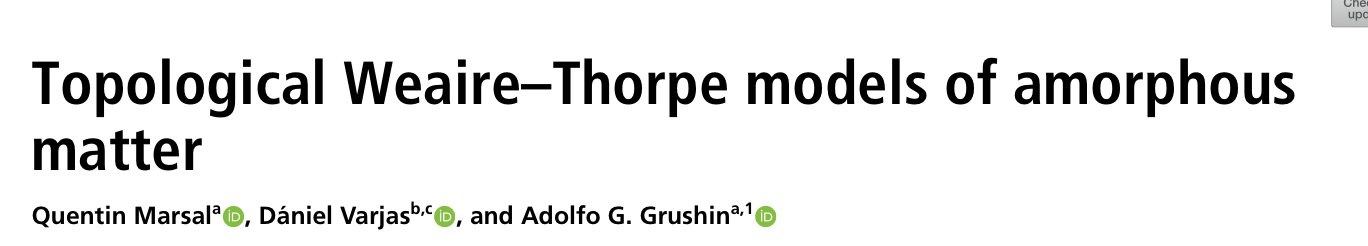

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.linalg import eigvalsh, qr
from numpy import linalg as lg

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

import koala

## Reproducing the lattice construction
<center>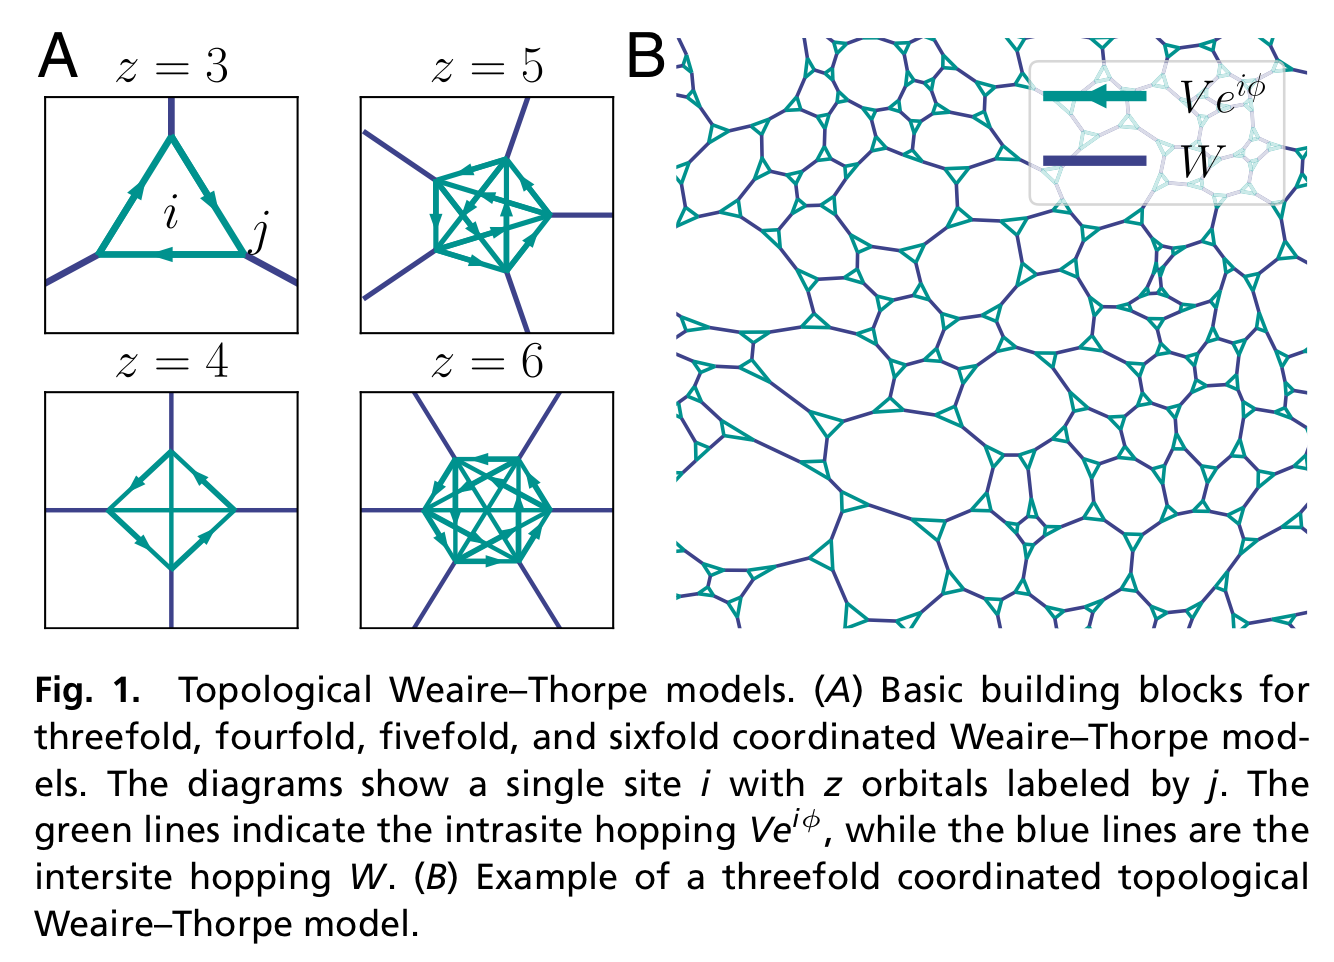</center>

# Start from an undirected graph generated from Voronisation

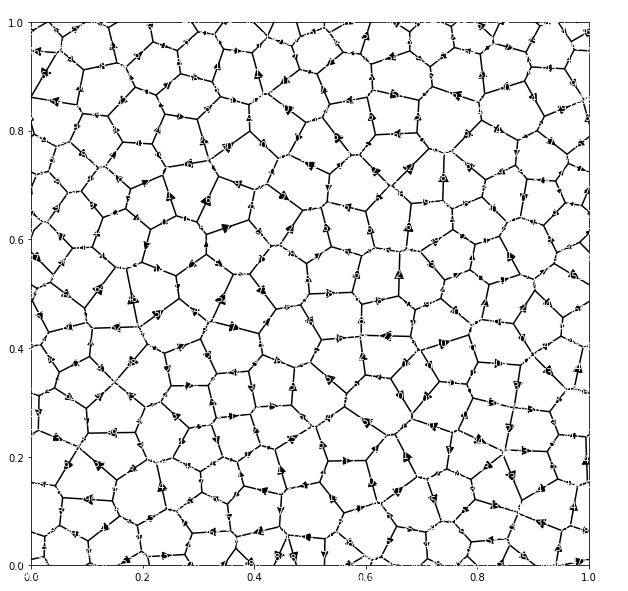

In [2]:
from koala.voronization import generate_point_array, generate_lattice
from koala.graph_utils import vertex_neighbours, clockwise_edges_about, clockwise_about, get_edge_vectors
from koala.plotting import plot_lattice, plot_degeneracy_breaking
from koala.pointsets import generate_bluenoise,  generate_random
from koala.graph_color import edge_color
from koala.lattice import Lattice
import itertools as it

# create approx n^2 points
n = 3 # default to small lattice to reduce computation time
#n = 15 #uncomment to do a more reasonably size lattice

#how many values of phi to do later
m = 3
#m = 40
    
fig, ax = plt.subplots()  
points =  generate_bluenoise(k = 100, nx = n, ny = n)
g = generate_lattice(points)

ordered_edge_indices = clockwise_edges_about(vertex_i = 0, g=g)
solveable, g_edge_labels = edge_color(g.edges.indices, n_colors = 3, fixed = enumerate(ordered_edge_indices))

plot_lattice(g, edge_arrows = True, edge_index_labels = True);

# Replace all the vertices with triangles, edges winding anticlockwise

<AxesSubplot:>

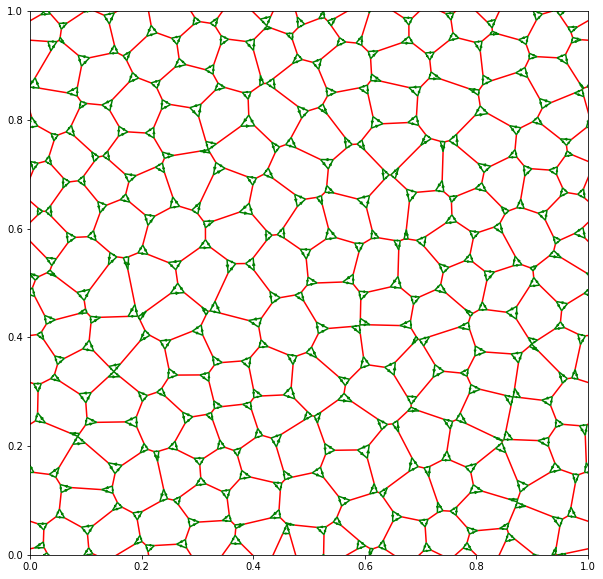

In [3]:
from koala.weaire_thorpe import vertices_to_triangles

WT_g = vertices_to_triangles(g, g_edge_labels);

edge_labels = np.where(np.arange(WT_g.edges.indices.shape[0]) < g.edges.indices.shape[0], 0, 1)
edge_arrows = np.where(np.arange(WT_g.edges.indices.shape[0]) < g.edges.indices.shape[0], 0, 1)

plot_lattice(WT_g, edge_arrows = edge_arrows, edge_labels = edge_labels)

## Dressing it with the hamiltonian 

$$ H = \sum_{i, \alpha \neq \beta} V_{\alpha \beta}c^\dagger_{i\alpha} c_{i\beta} + \sum_{\alpha, i \neq j} W c^\dagger_{i\alpha} c_{j\alpha}$$

<center>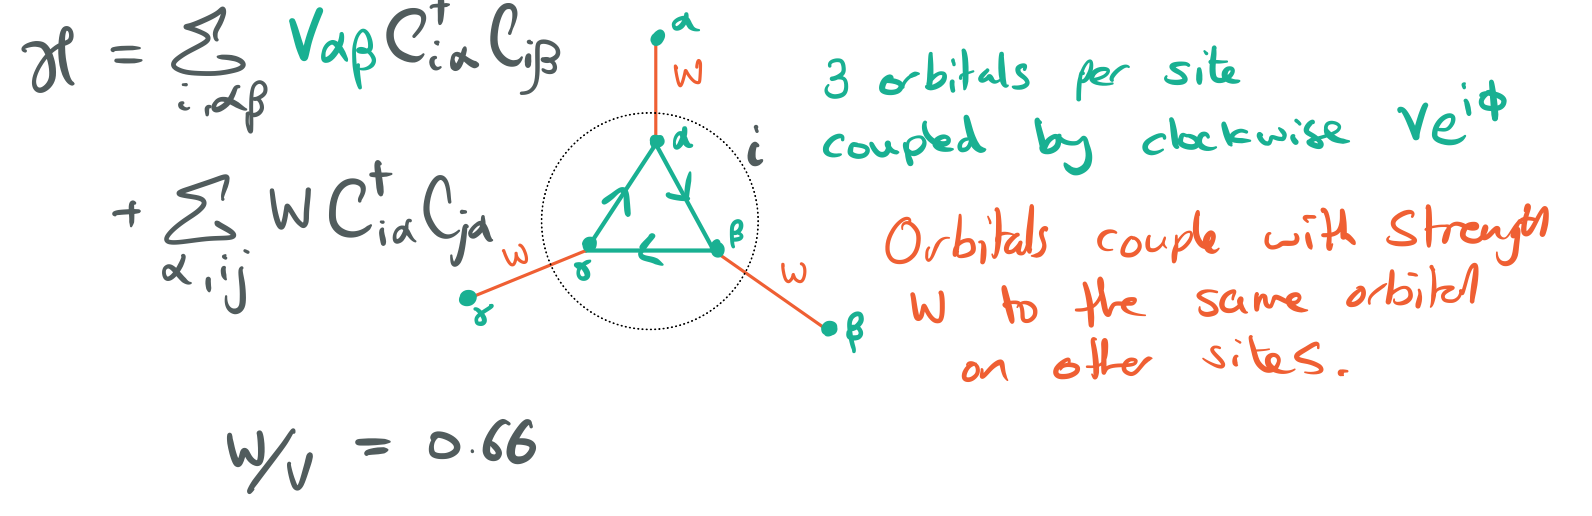</center>

In [4]:
from scipy import linalg as la
from numpy import pi
from koala.weaire_thorpe import cut_boundary, make_weire_thorpe_model
    
V = 1
W = 0.66
E_bound = 2*(V+W)

Es = np.linspace(-E_bound , E_bound , 100)

# #generate points
# n = 8
# points =  generate_bluenoise(k = 100, nx = n, ny = n)

# #generate graph
# g = generate_lattice(points)

# #color it
# ordered_edge_indices = clockwise_edges_about(vertex_i = 0, g=g)
# solveable, edge_labels = edge_color(g.edges.indices, n_colors = 3, fixed = enumerate(ordered_edge_indices))

# #transform it to a Weaire-Thorpe model
# solveable, edge_labels = edge_color(g.edges.indices, n_colors = 3, fixed = enumerate(ordered_edge_indices))
# WT_g = vertices_to_triangles(g, edge_labels);

#label the internal and external edges
edge_labels = np.where(np.arange(WT_g.edges.indices.shape[0]) < g.edges.indices.shape[0], 0, 1)
internal_edges = np.where(np.arange(WT_g.edges.indices.shape[0]) < g.edges.indices.shape[0], False, True)

#plot_lattice(WT_g, edge_arrows = internal_edges, edge_labels = edge_labels)

def compute_observables(WT_g, internal_edges, Es):

    #solve the hamiltonian
    eigvals, eigvecs = make_weire_thorpe_model(WT_g, internal_edges = internal_edges, phi = 1.3, V = 1, W = 0.66)
    density = np.abs(eigvecs)
    IPR = 1 / np.sum(np.abs(eigvecs)**4, axis = 0) / len(WT_g.vertices.positions)
    
    #bin the energies
    DOS, _ = np.histogram(eigvals, Es)
    return eigvals, eigvecs, DOS, density, IPR

eigvals, eigvecs, DOS, density, IPR = compute_observables(WT_g, internal_edges, Es)

#cut all the edges that cross boundaries
kept_edges, WT_g_open = cut_boundary(WT_g)
internal_edges_open = internal_edges[kept_edges]
edge_labels_open = edge_labels[kept_edges]

eigvals_open, eigvecs_open, DOS_open, density_open, IPR_open = compute_observables(WT_g_open, internal_edges[kept_edges], Es)

0.014263076570693065 1.0000000000000022
0.001022494887525563 0.6848095137343987
E_target = 1.0458, closest_i = 659, E_closest = 1.057870459305354


[(-2.0, 2.0)]

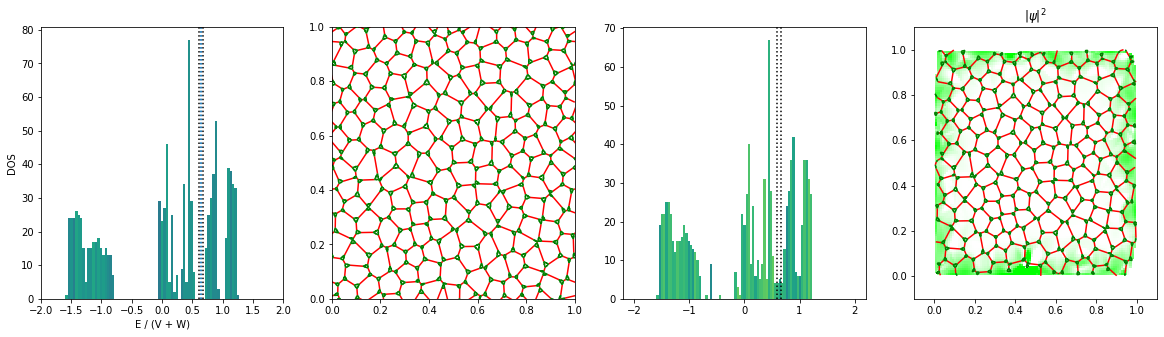

In [5]:
from koala.plotting import plot_scalar

fig, axes = plt.subplots(ncols = 4, figsize = (20,5))

#plot the barcharts

def colormap(a): return plt.get_cmap('viridis')((a - min(a)) / (max(a) - min(a)))
print(min(IPR), max(IPR))
print(min(IPR_open), max(IPR_open))

width = (Es[1] - Es[0]) / (V + W)
axes[0].bar(Es[:-1] / (V + W), DOS, width = width, align = 'edge', color = colormap(IPR))
axes[2].bar(Es[:-1] / (V + W), DOS_open, width = width, align = 'edge', color = colormap(IPR_open))

plot_lattice(WT_g, edge_arrows = internal_edges, ax = axes[1], edge_labels = edge_labels)

E_target = 0.63 * (V + W)
E_interval = np.array([0.60, 0.67]) * (V + W)

closest_i = np.searchsorted(eigvals_open, E_target)
E_closest = eigvals_open[closest_i]
print(f"E_target = {E_target}, closest_i = {closest_i}, E_closest = {E_closest}")

plot_lattice(WT_g_open, edge_arrows = internal_edges_open, ax = axes[3], edge_labels = edge_labels_open)

in_interval = np.logical_and(E_interval[0] < eigvals_open, eigvals_open < E_interval[1])
local_DOS_open = np.sum(density_open[:, in_interval], axis = 1)

in_interval = np.logical_and(E_interval[0] < eigvals, eigvals < E_interval[1])
local_DOS = np.sum(density[:, in_interval], axis = 1)

plot_scalar(WT_g, local_DOS, ax = axes[1])
plot_scalar(WT_g_open, local_DOS_open, ax = axes[3])
#plot_wavefunction(WT_g_open, density_open[closest_i, :], ax = axes[3])
#axes[0].axvline(x = E_closest / (V + W), linestyle = 'dotted')
s = 0.1
axes[3].set(xlim = (-s,1+s), ylim = (-s,1+s))

axes[0].set(ylabel = "DOS", xlabel = "E / (V + W)")
axes[3].set(title = "$|\psi|^2$")

for i in [0,2]:
    axes[0].axvline(x = E_closest / (V + W), linestyle = 'dotted')
    for e in E_interval: 
        axes[i].axvline(x = e / (V+W), linestyle = 'dotted', color = 'k')
        
axes[0].set(xlim = (-E_bound/(V+W), E_bound/(V+W)))

## DOS as a function of phi

In [6]:
#generate points
points =  generate_bluenoise(k = 100, nx = n, ny = n)

#generate graph
g = generate_lattice(points)

#color it
ordered_edge_indices = clockwise_edges_about(vertex_i = 0, g=g)
solveable, edge_labels = edge_color(g.edges.indices, n_colors = 3, fixed = enumerate(ordered_edge_indices))

#transform it to a Weaire-Thorpe model
solveable, edge_labels = edge_color(g.edges.indices, n_colors = 3, fixed = enumerate(ordered_edge_indices))
WT_g = vertices_to_triangles(g, edge_labels);

#label the internal and external edges
edge_labels = np.where(np.arange(WT_g.edges.indices.shape[0]) < g.edges.indices.shape[0], 0, 1)
internal_edges = np.where(np.arange(WT_g.edges.indices.shape[0]) < g.edges.indices.shape[0], False, True)

#solve the hamiltonian
eigvals, eigvecs = make_weire_thorpe_model(WT_g, internal_edges = internal_edges, phi = 1.3, V = 1, W = 0.66)
DOS, _ = np.histogram(eigvals, Es)

phis = np.linspace(0,pi,m)
ms = np.array([-1,0,1])

DOSs = np.zeros(shape = (m, len(Es)-1))
for i, phi in enumerate(phis):
    #solve the hamiltonian
    eigvals, eigvecs = make_weire_thorpe_model(WT_g, internal_edges = internal_edges, phi = phi, V = 1, W = 0.66)
    density = np.abs(eigvecs)

    #bin the energies
    DOSs[i], _ = np.histogram(eigvals, Es)

[Text(0.5, 0, '$\\phi$'), Text(0, 0.5, '$E / (W + V)$')]

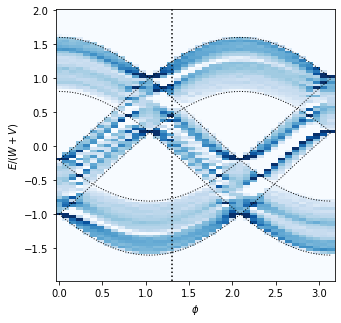

In [7]:
from scipy.optimize import root

def bands(Ev, phiv):
    m = 0
    return np.any([np.abs(Ev - 2*V*np.cos(phiv + m * 2*pi/3)) < np.abs(W) for m in ms], axis = 0)

def band_edges(phi):
    def f(E, phi): return np.abs(E - 2*V*np.cos(phi + m * 2*pi/3)) - np.abs(W)
    roots = np.empty(shape = (phi.shape[0],3,2), dtype = float)
    for i,m in enumerate([-1,0,1]):
        for j,sign in enumerate([-1,1]):
            roots[:, i, j] = root(f, x0 = sign*E_bound*np.ones_like(phi), args = (phi,)).x
    roots = np.sort(roots, axis = -1).reshape(-1, 6)
    return roots

fig, axes = plt.subplots(ncols = 1, figsize = (5,5))
axes.pcolor(phis, Es[1:,]/(V + W), DOSs.T, cmap = 'Blues', vmax = np.max(DOSs)*0.3)

edges = band_edges(phis)
axes.plot(phis, edges / (V + W), color = 'k', linewidth = 1, linestyle = 'dotted', zorder = 3)
axes.axvline(x = 1.3, linestyle = 'dotted', color = 'k')
axes.set(xlabel = "$\phi$", ylabel = "$E / (W + V)$")

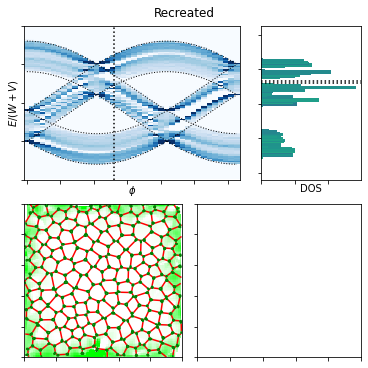

In [8]:
from matplotlib.gridspec import GridSpec

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)

energy_lim = (-2,2) #the limits to use for energy axes
        
fig = plt.figure(constrained_layout=True, figsize = (5,5))

top_ratio = (8,4)
width = sum(top_ratio)
gs = GridSpec(2, width, figure=fig)
ax1 = fig.add_subplot(gs[0, :top_ratio[0]])
ax2 = fig.add_subplot(gs[0, top_ratio[0]:])
ax3 = fig.add_subplot(gs[1, :width//2])
ax4 = fig.add_subplot(gs[1, width//2:])

#plot the graph of DOS vs phi
ax = ax1
edges = band_edges(phis)
ax.pcolor(phis, Es[1:,]/(V + W), DOSs.T, cmap = 'Blues', vmax = np.max(DOSs)*0.3)
ax.plot(phis, edges / (V + W), color = 'k', linewidth = 1, linestyle = 'dotted', zorder = 3)
ax.axvline(x = 1.3, linestyle = 'dotted', color = 'k')
ax.set(xlabel = "$\phi$", ylabel = "$E / (W + V)$", ylim = energy_lim)

#plot the graph of DOS at phi = 1.3
ax = ax2
ax.set(xlabel = "DOS")
#ax.plot(DOS, Es[1:] / (V + W))
ax.barh(y = Es[:-1] / (V + W), width = DOS, height = 0.1, align = 'edge', color = colormap(IPR))

for e in E_interval: 
    ax.axhline(y = e / (V+W), linestyle = 'dotted', color = 'k')


#plot the edge state
ax = ax3
plot_lattice(WT_g_open, edge_arrows = internal_edges_open, ax = ax, edge_labels = edge_labels_open)
plot_scalar(WT_g_open, local_DOS_open, ax = ax)

fig.suptitle("Recreated")
format_axes(fig)

## Reproducing this figure from the paper:
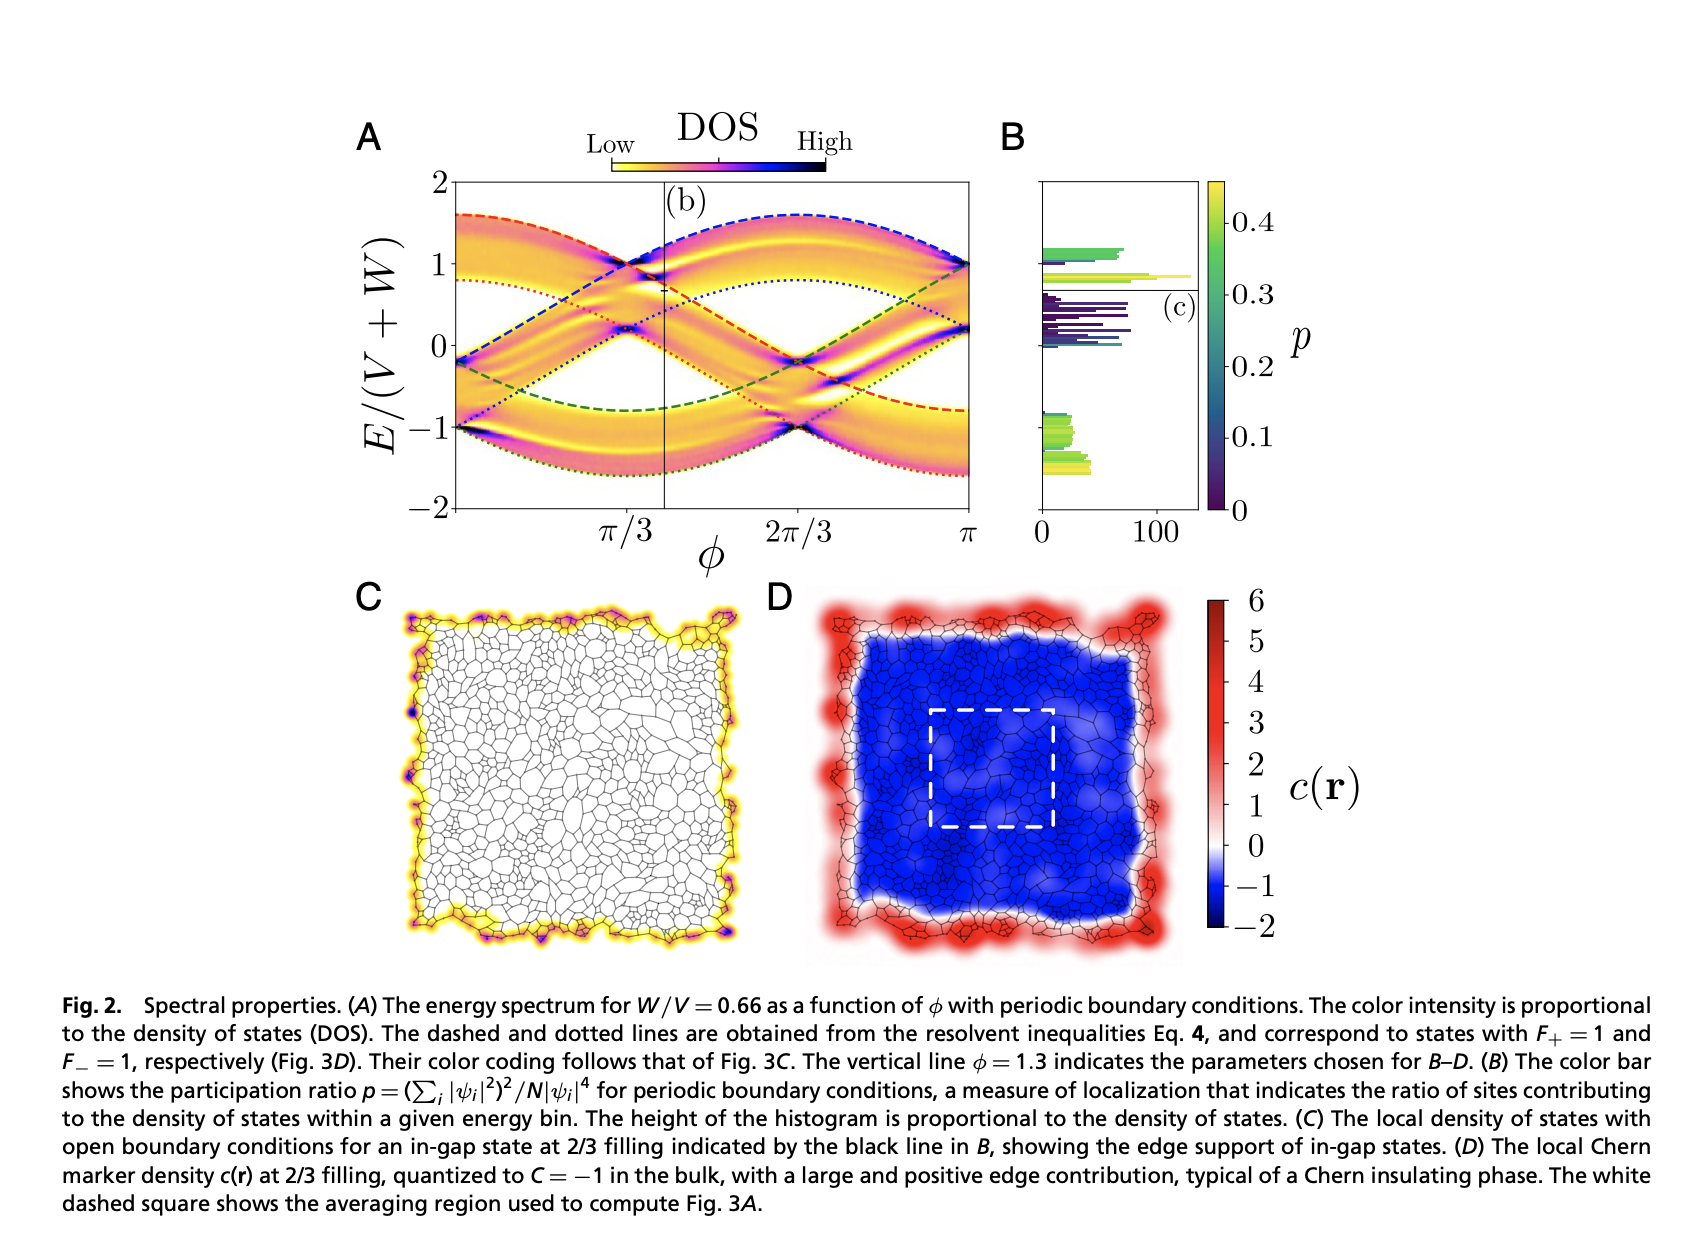